In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('paper2.png')

In [2]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

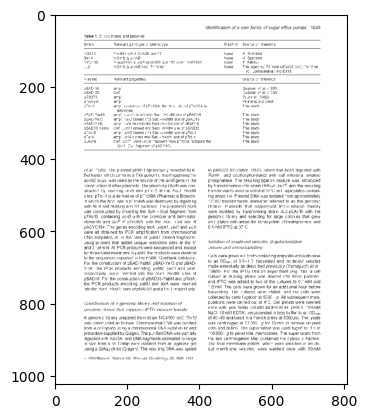

In [3]:
img = cv2.imread('paper2.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


ret, thresh = cv2.threshold(imgray, 130, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')
plt.show()

In [4]:
array = np.array(thresh)


In [5]:
array.shape

(1024, 810)

In [6]:
#row
row_sums = np.sum(array, axis=1)

print("Shape of row_sums array:", row_sums.shape)

print(row_sums)

Shape of row_sums array: (1024,)
[206550 206550 206550 ... 206550 206550 206550]


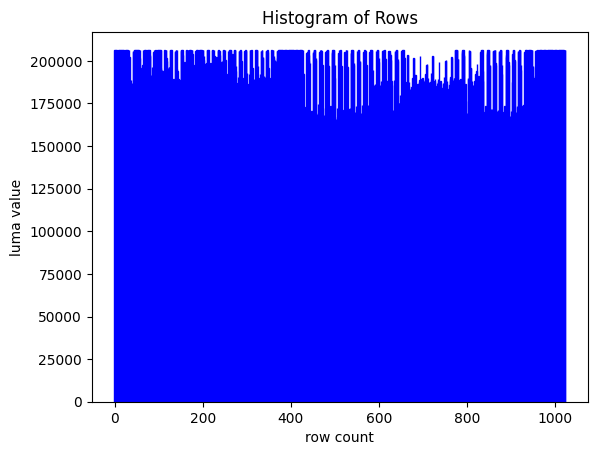

In [7]:
indices = np.arange(len(row_sums))

plt.bar(indices, row_sums, edgecolor='blue')

plt.title('Histogram of Rows')
plt.xlabel('row count')
plt.ylabel('luma value')

plt.show()

In [8]:
########       Trim the top and bottom white margin     ############

def trim_white_margins(pixel_array):
    row_sums = np.sum(pixel_array, axis=1)
    num_columns = pixel_array.shape[1]
    white_row_sum = 255 * num_columns

    # Find the first non-white row from the top
    start_index = 0
    while start_index < len(row_sums) and row_sums[start_index] == white_row_sum:
        start_index += 1

    # Find the first non-white row from the bottom
    end_index = len(row_sums) - 1
    while end_index >= 0 and row_sums[end_index] == white_row_sum:
        end_index -= 1

    # Trim the pixel array
    row_trimmed_array = pixel_array[start_index:end_index+1, :]

    return row_trimmed_array


######### Crop out the left and right margin ###########
def trim_white_margins_lr(pixel_array):
    col_sums = np.sum(pixel_array, axis=0)
    num_rows = pixel_array.shape[0]
    white_col_sum = 255 * num_rows

    # Find the first non-white column from the left
    start_index = 0
    while start_index < len(col_sums) and col_sums[start_index] == white_col_sum:
        start_index += 1

    # Find the first non-white column from the right
    end_index = len(col_sums) - 1
    while end_index >= 0 and col_sums[end_index] == white_col_sum:
        end_index -= 1

    # Trim the pixel array
    col_trimmed_array = pixel_array[:, start_index:end_index+1]

    return col_trimmed_array

row_trimmed_array = trim_white_margins(array)
marginless_array = trim_white_margins_lr(row_trimmed_array)

print("Trimmed Array:")
print(marginless_array)
marginless_array.shape


Trimmed Array:
[[255 255 255 ...   0 255 255]
 [255 255 255 ... 255   0 255]
 [255 255 255 ... 255   0 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


(926, 654)

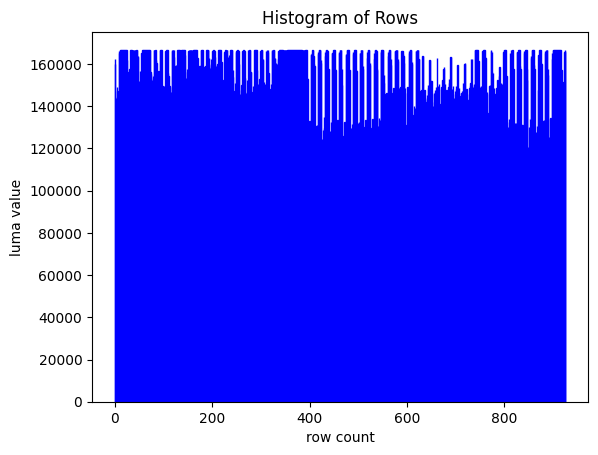

In [9]:
row_sums = np.sum(marginless_array, axis=1)
indices = np.arange(len(row_sums))

plt.bar(indices, row_sums, edgecolor='blue')

plt.title('Histogram of Rows')
plt.xlabel('row count')
plt.ylabel('luma value')

plt.show()


In [10]:
np.savetxt('large_array.txt', marginless_array, fmt='%d')


In [15]:
def calculate_row_sums(image, threshold=255):
    num_rows, num_columns = image.shape
    white_row_sum = threshold * num_columns
    row_sums = np.sum(image, axis=1)
    return row_sums, white_row_sum

def identify_line_gaps(row_sums, white_row_sum):
    white_space_lengths = []
    current_length = 0

    for value in row_sums:
        if value == white_row_sum:
            current_length += 1
        else:
            if current_length > 0:
                white_space_lengths.append(current_length)
                current_length = 0

    if current_length > 0:
        white_space_lengths.append(current_length)

    if white_space_lengths:
        average_line_gap = np.mean(white_space_lengths)
    else:
        average_line_gap = 0

    return average_line_gap, white_space_lengths

def find_significant_gaps(row_sums, white_row_sum, average_line_gap, gap_multiplier=1.5):
    significant_gaps = []
    current_length = 0
    significant_threshold = average_line_gap * gap_multiplier

    for i, value in enumerate(row_sums):
        if value == white_row_sum:
            current_length += 1
        else:
            if current_length >= significant_threshold:
                significant_gaps.append((i - current_length, i))
            current_length = 0

    if current_length > significant_threshold:
        significant_gaps.append((len(row_sums) - current_length, len(row_sums)))

    return significant_gaps

def divide_image(image, significant_gaps):
    parts = []
    start = 0
    for gap_start, gap_end in significant_gaps:
        parts.append((start, gap_start))
        start = gap_end
    parts.append((start, image.shape[0]))
    return parts

row_sums, white_row_sum = calculate_row_sums(marginless_array)
average_line_gap, white_space_lengths = identify_line_gaps(row_sums, white_row_sum)
significant_gaps = find_significant_gaps(row_sums, white_row_sum, average_line_gap)

print("Average Line Gap Height:", average_line_gap)
print("Significant Gaps (row indices):", significant_gaps)

parts = divide_image(marginless_array, significant_gaps)
print(parts)
# for i, part in enumerate(parts):
#     print(f"Part {i + 1} shape:", part.shape)


Average Line Gap Height: 4.666666666666667
Significant Gaps (row indices): [(11, 25), (40, 47), (63, 73), (136, 144), (159, 168), (344, 395), (900, 916)]
[(0, 11), (25, 40), (47, 63), (73, 136), (144, 159), (168, 344), (395, 900), (916, 926)]


8


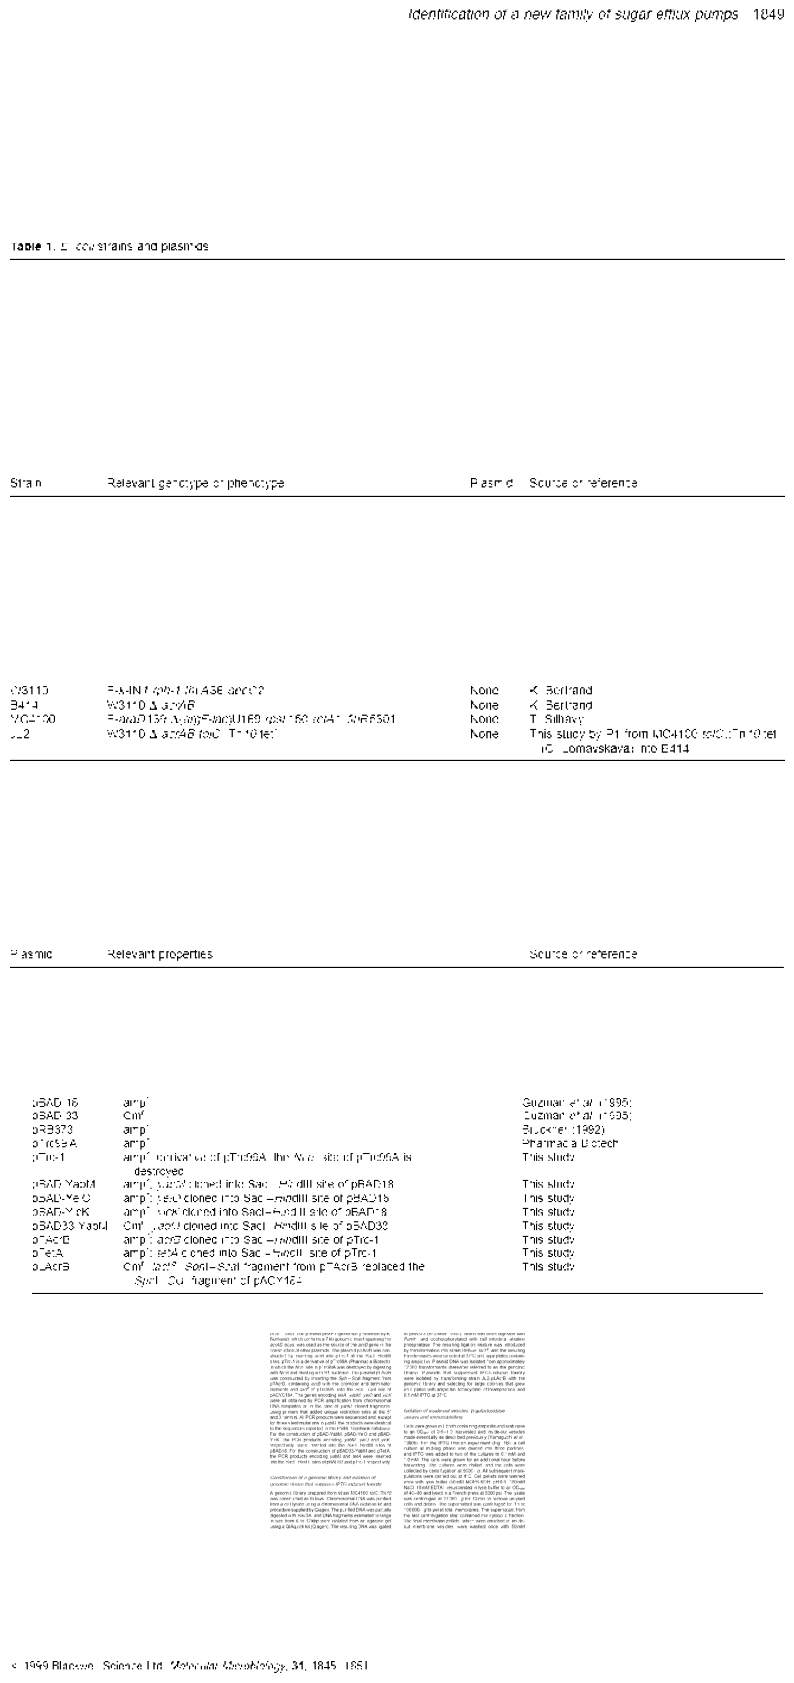

In [17]:
def display_image_parts(image, parts):
    num_parts = len(parts)
    print(num_parts)
    fig, axes = plt.subplots(num_parts, 1, figsize=(10, num_parts * 3))
    if num_parts == 1:
        axes = [axes]  # To handle the case when there's only one part
    for i, (start, end) in enumerate(parts):
        part = image[start:end, 0:image.shape[1]]
        axes[i].imshow(part, cmap='gray')
        axes[i].axis('off')
    plt.show()

display_image_parts(marginless_array, parts)